In [220]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import date
from datetime import timedelta
from dateutil.relativedelta import relativedelta

<Axes: >

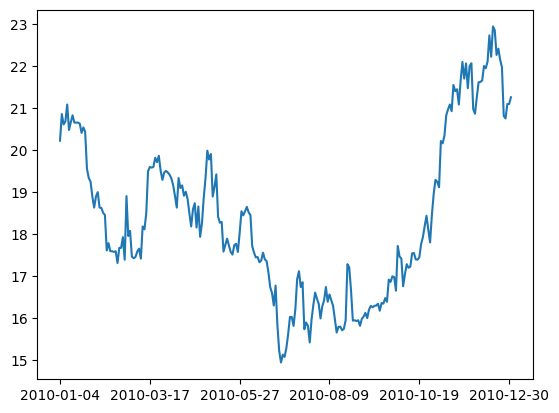

In [221]:
pd.read_csv("./dataset/Close.csv",index_col = 0).T['iba.us'].loc['2010-01-01':'2011-01-01'].plot()

In [222]:
start_date = date.fromisoformat('2009-12-31')

In [223]:
end_date = date.fromisoformat('2014-12-31')

In [224]:
def make_data_dict(path = './dataset/', start_date= start_date, end_date = end_date):
    data_sources = ['Close.csv','Open.csv','High.csv','Low.csv','Volume.csv']
    data_dict = {}
    for source in data_sources:
        data_dict[source[:-4]] = pd.read_csv(path + source, index_col = 0).T.loc[start_date.isoformat():end_date.isoformat()]
    return data_dict

In [225]:
data_dict = make_data_dict()

In [226]:
close = data_dict['Close']
opn = data_dict['Open']
high = data_dict['High']
low = data_dict['Low']
volume = data_dict['Volume']

In [227]:
pd.date_range(start_date , end_date, freq='Y')

DatetimeIndex(['2009-12-31', '2010-12-31', '2011-12-31', '2012-12-31',
               '2013-12-31', '2014-12-31'],
              dtype='datetime64[ns]', freq='A-DEC')

In [228]:
class Alpha():
    def __init__(self, data_dict, start_date, end_date):
        self.start_date = start_date
        self.end_date = end_date
        self.weights = data_dict['Close']
        self.opn = data_dict['Open']
        self.close = data_dict['Close']
        self.volume = data_dict['Volume']
        self.low = data_dict['Low']
        self.high = data_dict['High']
        self.calc_weights()
        self.turnover = self.calc_turnover()
        self.pnl = self.calc_pnl()
        self.cumsum = self.calc_cumsum()
        self.cumrtrn = self.calc_cumrtrn()
        self.sharpe = self.calc_sharpe()
        self.drawdown = self.calc_drawdown()
    
    def calc_turnover(self, start_date=None, end_date=None):
        start_date = start_date if start_date is not None else self.start_date
        end_date = end_date if end_date is not None else self.end_date
        turnovers = []
        for year_start in pd.date_range(start=start_date, end=end_date - relativedelta(years=1), freq='Y'):
            year_end = year_start + relativedelta(years=1)
            turnovers.append(self.weights.loc[year_start.isoformat():year_end.isoformat()].diff().abs().sum(axis=1).mean())
        return turnovers
    
    def calc_pnl(self, start_date=None, end_date=None):
        start_date = start_date if start_date is not None else self.start_date
        end_date = end_date if end_date is not None else self.end_date
        return (self.close.pct_change() * self.weights.shift(2)).sum(axis=1).loc[start_date.isoformat():end_date.isoformat()]
    
    def calc_cumrtrn(self, start_date=None, end_date=None):
        start_date = start_date if start_date is not None else self.start_date
        end_date = end_date if end_date is not None else self.end_date
        cumrtrns = []
        length = len(self.cumsum)
        i = 252
        if length < 252:
            cumrtrns.append(self.cumsum.iloc[length] - self.cumsum.iloc[0])
            
        while i < length:
            cumrtrns.append(self.cumsum.iloc[i] - self.cumsum.iloc[i - 252])
            i = i + 252
            if abs(i - length - 1) < 5: 
                i = length - 1
        return cumrtrns 
    
    def check_parametrs(self):
        cumsum_test = True if self.cumsum.iloc[-1] >= 0.3 else False
        sharpe_test =  True if sum(sharpe >= 1 for sharpe in self.sharpe) >= 3 else False
        turnover_test = True if np.mean(self.turnover) <= 0.8 else False 
        test_results = {
            'cumsum': cumsum_test,
            'sharpe': sharpe_test,
            'turnover': turnover_test
        }
        print("\nResults of Tests:")
        print("-" * 20)
        for test_name, result in test_results.items():
            print(f"{test_name.capitalize()} test {'passed' if result else 'failed'}.")

    def rank(self):
        self.weights = (self.weights.rank(axis=1) - 1) / (self.weights.shape[1] - 1)
        self.alpha_processing()
        self.alpha_update()
    
    def cut_outliers(self, n=50):
        sorted_weights = self.weights.values.argsort(axis=1)
        n_cols = self.weights.shape[1]
        outlier_indices = np.concatenate([sorted_weights[:, :n], sorted_weights[:, -n:]], axis=1)
        self.weights.values[np.arange(len(self.weights))[:, None], outlier_indices] = 0
        self.alpha_processing()
        self.alpha_update()

    
    def cut_middle(self, n = 50):
        sorted_weights = self.weights.values.argsort(axis=1)
        n_cols = self.weights.shape[1]
        middle_start = (n_cols - n) // 2
        middle_end = middle_start + n
        self.weights.values[np.arange(len(self.weights))[:, None], sorted_weights[:, middle_start:middle_end]] = 0
        self.alpha_processing()
        self.alpha_update()
        
    def decay(self,window):
        self.weights = self.weights.ewm(span=window).mean()
        self.alpha_processing()
        self.alpha_update()
    
    def var(self):
        return self.weights.pct_change().var(axis=1)
    
    def plot_correlation(self, pnls):
        fig, axs = plt.subplots(figsize=(10,10))
        sns.heatmap(pnls.corr(), annot=True)
    
    def calc_corr(self,vpnl1,vpnl2):
        return vpnl1.corr(vpnl2)
        #return vpnl1.cov(vpnl2)/(vpnl1.std() * vpnl2.std())
        
    def calc_cumsum(self, start_date=None, end_date=None):
        start_date = start_date if start_date is not None else self.start_date
        end_date = end_date if end_date is not None else self.end_date
        return self.pnl.cumsum().loc[start_date.isoformat():end_date.isoformat()]
        
    def calc_sharpe(self, start_date=None, end_date=None):
        start_date = start_date if start_date is not None else self.start_date
        end_date = end_date if end_date is not None else self.end_date
        sharpes = []
        for year_start in pd.date_range(start_date, end_date - relativedelta(years=1), freq='Y'):
            year_end = year_start + relativedelta(years=1)
            sharpes.append(self.pnl.loc[year_start.isoformat():year_end.isoformat()].mean() / self.pnl.loc[year_start.isoformat():year_end.isoformat()].std() * np.sqrt(252))
        return sharpes
    
    def calc_drawdown(self, start_date=None, end_date=None):
        start_date = start_date if start_date is not None else self.start_date
        end_date = end_date if end_date is not None else self.end_date
        dd = []
        for year_start in pd.date_range(start_date, end_date - relativedelta(years=1), freq='Y'):
            year_end = year_start + relativedelta(years=1)
            mdd = 0
            mcpnl = 0
            cumsum = self.calc_cumsum(year_start, year_end)
            for a in cumsum:
                mcpnl = max(a,mcpnl)
                mdd = max(mcpnl - a,mdd)
            dd.append(mdd)    
        return dd
            
    def truncate(self, threshold=0.01):
        current_threshold = threshold * 0.9
        max_iterations = 5
        for _ in range(max_iterations):
            self.weights = self.weights.clip(-current_threshold, current_threshold)
            self.weights[self.weights > 0] = self.weights[self.weights > 0].div(2 * self.weights[self.weights > 0].sum(axis=1), axis=0)
            self.weights[self.weights < 0] = self.weights[self.weights < 0].div(-2 * self.weights[self.weights < 0].sum(axis=1), axis=0)
            self.alpha_processing()
        self.alpha_update()
    
    def get_stats(self, start_date=None, end_date=None):
        start_date = start_date if start_date is not None else self.start_date
        end_date = end_date if end_date is not None else self.end_date
        self.alpha_update(start_date, end_date)
        stats_data = {
        'Sharpe Ratio': self.sharpe,
        'Turnover': self.turnover,
        'Cumulative Return': self.cumrtrn,
        'Drawdown': self.drawdown
        }
        stats_df = pd.DataFrame(stats_data)
        stats_df.index = pd.date_range(start_date, end_date, freq='Y')[1:].year
        self.plot()
        return stats_df
        
    def run_exp(self):
        return 
    
    def plot(self):
        self.cumsum.plot()
    
    def alpha_update(self, start_date=None, end_date=None):
        start_date = start_date if start_date is not None else self.start_date
        end_date = end_date if end_date is not None else self.end_date
        
        self.turnover = self.calc_turnover(start_date,end_date)
        self.pnl = self.calc_pnl(start_date,end_date)
        self.cumsum = self.calc_cumsum(start_date,end_date)
        self.sharpe = self.calc_sharpe(start_date,end_date)
        self.drawdown = self.calc_drawdown(start_date,end_date)
    
    def alpha_processing(self):
        self.neutralization()
        self.normalization()
    
    def calc_weights(self):
        pass
    
    def normalization(self):
        self.weights = self.weights.div(self.weights.abs().sum(axis=1),axis=0)
    
    def neutralization(self):
        self.weights = self.weights.sub(self.weights.mean(axis=1), axis=0)
    

In [229]:
alpha_BOSS_OF_CORRELATIONS = Alpha(data_dict, start_date, end_date) #Main Alpha which tells about Correlations of other alphas

In [230]:
class Alpha_1(Alpha):
    def calc_weights(self):
        self.weights =  self.opn / self.close
        self.alpha_processing()

In [231]:
alpha_1 = Alpha_1(data_dict, start_date, end_date)

In [232]:
alpha_1.truncate()

In [233]:
alpha_1.truncate()

In [234]:
alpha_1.decay(40)

,Sharpe Ratio,Turnover,Cumulative Return,Drawdown
2010,0.799533,0.281656,0.107662,0.059661
2011,2.247246,0.270815,0.084435,0.030435
2012,2.681626,0.266488,0.097569,0.046934
2013,1.064267,0.261063,0.022044,0.033379
2014,-0.191325,0.272838,-0.009338,0.100957


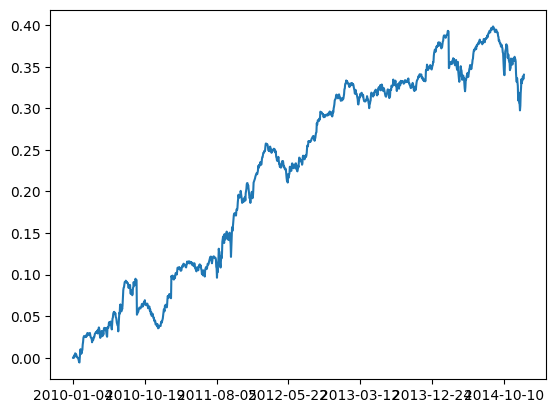

In [235]:
alpha_1.get_stats()

In [236]:
alpha_1.check_parametrs()


Results of Tests:
--------------------
Cumsum test passed.
Sharpe test passed.
Turnover test passed.


In [237]:
alpha_1.weights.sum(axis=1).round().sum()

0.0

In [238]:
alpha_1.weights.abs().sum(axis=1).sum()

1257.0

In [239]:
class Alpha_2(Alpha):
    def calc_weights(self):
        self.weights = - self.close.shift(1) / self.close.shift(6) 
        self.alpha_processing()

In [240]:
alpha_2 = Alpha_2(data_dict, start_date, end_date)

In [241]:
alpha_2.rank()

In [242]:
alpha_2.rank()

In [243]:
alpha_2.truncate()

In [244]:
alpha_2.decay(2)

In [245]:
alpha_2.truncate()

,Sharpe Ratio,Turnover,Cumulative Return,Drawdown
2010,1.977807,0.444656,0.124117,0.020133
2011,2.047876,0.461243,0.131566,0.043585
2012,2.504189,0.454995,0.112085,0.020644
2013,1.521893,0.451140,0.028687,0.015822
2014,0.013265,0.448103,0.027331,0.055464


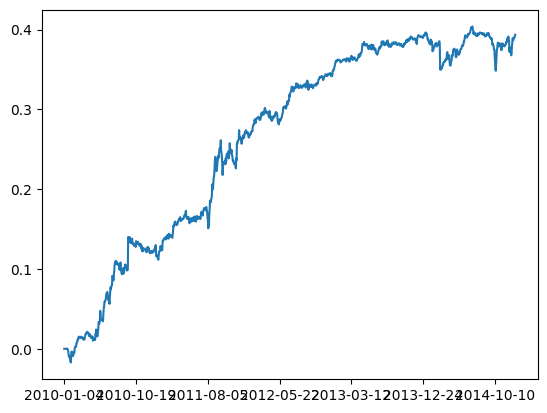

In [246]:
alpha_2.get_stats()

In [247]:
alpha_2.check_parametrs()


Results of Tests:
--------------------
Cumsum test passed.
Sharpe test passed.
Turnover test passed.


In [248]:
class Alpha_3(Alpha):
    def calc_weights(self):
        self.weights = ((-1 * ((self.low - self.close) * (self.opn * self.opn * self.opn * self.opn * self.opn))) / ((self.low - self.high) * (self.close * self.close * self.opn *  self.close *  self.close)))
        self.alpha_processing()

In [249]:
alpha_3 = Alpha_3(data_dict, start_date, end_date)

In [250]:
alpha_3.cut_middle(2000)

In [251]:
alpha_3.decay(4)

,Sharpe Ratio,Turnover,Cumulative Return,Drawdown
2010,1.452526,0.797908,-0.000252,0.025714
2011,2.193576,0.798579,0.050645,0.041321
2012,2.157250,0.788147,0.039105,0.019872
2013,3.099583,0.787168,0.011556,0.016211
2014,1.193065,0.791202,-0.041162,0.029408


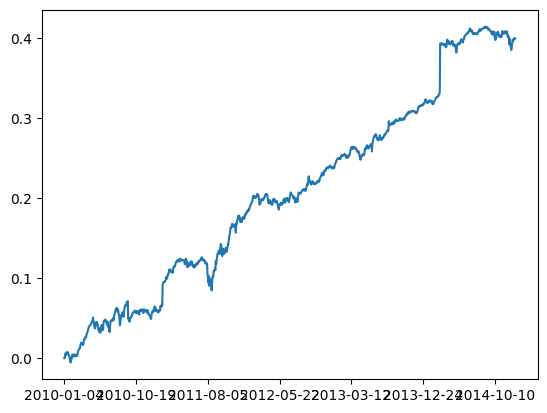

In [252]:
alpha_3.get_stats()

In [253]:
alpha_3.check_parametrs()


Results of Tests:
--------------------
Cumsum test passed.
Sharpe test passed.
Turnover test passed.


In [254]:
class Alpha_4(Alpha):
    def calc_weights(self):
        self.weights =  (high * low) / (close * close)
        self.rank()

In [255]:
alpha_4 = Alpha_4(data_dict, start_date, end_date)

In [256]:
alpha_4.decay(15)

In [257]:
alpha_4.cut_middle(1500)

In [258]:
alpha_4.decay(6)

,Sharpe Ratio,Turnover,Cumulative Return,Drawdown
2010,0.418588,0.232835,0.020087,0.054318
2011,2.211699,0.233763,0.084198,0.023456
2012,2.303189,0.225222,0.042654,0.026295
2013,1.619908,0.226263,0.026752,0.021529
2014,0.898938,0.230625,-0.014164,0.030468


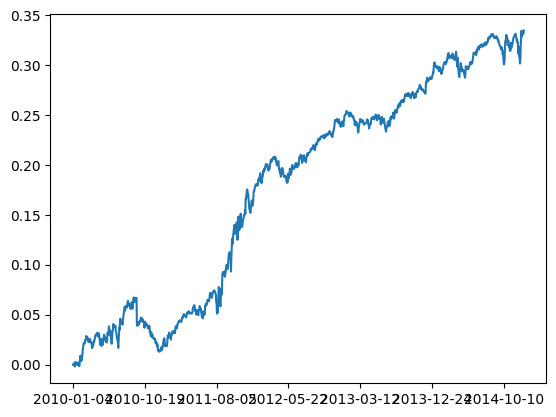

In [259]:
alpha_4.get_stats()

In [260]:
alpha_4.check_parametrs()


Results of Tests:
--------------------
Cumsum test passed.
Sharpe test passed.
Turnover test passed.


In [261]:
#-(self.close - self.low)/(self.high - self.low)

In [262]:
class Alpha_5(Alpha):
    def calc_weights(self):
        self.weights = alpha_1.weights + alpha_4.weights * alpha_BOSS_OF_CORRELATIONS.calc_corr(alpha_1.pnl, alpha_4.pnl)
        self.alpha_processing()

In [263]:
alpha_5 = Alpha_5(data_dict, start_date, end_date)

In [264]:
alpha_5.decay(6)

In [265]:
alpha_5.cut_middle(1000)

In [266]:
alpha_5.decay(5)

,Sharpe Ratio,Turnover,Cumulative Return,Drawdown
2010,0.073476,0.105276,0.042384,0.055613
2011,1.283822,0.103456,0.163784,0.035045
2012,1.745917,0.102124,0.100858,0.049513
2013,0.475000,0.100135,0.052961,0.048110
2014,-0.347394,0.103394,0.010105,0.102712


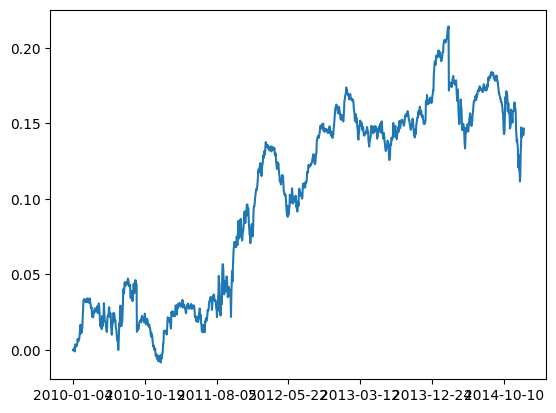

In [267]:
alpha_5.get_stats()

In [268]:
alpha_5.check_parametrs()


Results of Tests:
--------------------
Cumsum test failed.
Sharpe test failed.
Turnover test passed.


In [269]:
class Alpha_6(Alpha):
    def calc_weights(self):
        self.weights = -self.close
        self.alpha_processing()

In [270]:
alpha_6 = Alpha_6(data_dict, start_date, end_date)

In [271]:
alpha_6.truncate()

In [272]:
alpha_6.truncate()

In [273]:
alpha_6.cut_middle(500)

,Sharpe Ratio,Turnover,Cumulative Return,Drawdown
2010,1.006584,0.005890,0.195709,0.084460
2011,2.326136,0.020492,0.332549,0.056601
2012,0.833634,0.012109,0.007673,0.125406
2013,-1.589210,0.004780,-0.263804,0.236131
2014,2.334549,0.030830,0.659019,0.108813


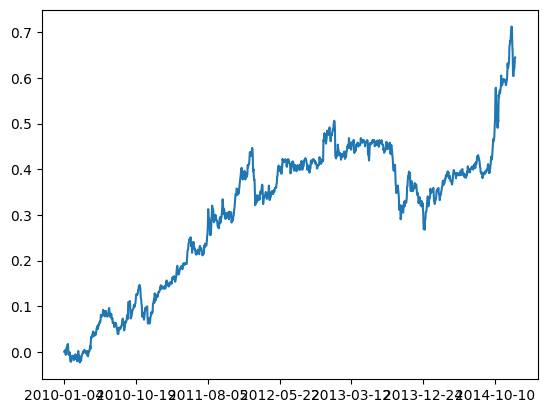

In [274]:
alpha_6.get_stats()

In [275]:
alpha_6.check_parametrs()


Results of Tests:
--------------------
Cumsum test passed.
Sharpe test passed.
Turnover test passed.


In [276]:
class Alpha_7(Alpha):
    def calc_weights(self):
        self.weights = - ((self.volume - self.volume.shift(1)) /((self.volume - self.volume.shift(1)).abs())) * (self.close - self.close.shift(1))
        self.alpha_processing()

In [277]:
alpha_7 = Alpha_7(data_dict, start_date, end_date)

In [278]:
alpha_7.decay(4)

,Sharpe Ratio,Turnover,Cumulative Return,Drawdown
2010,0.830659,0.606407,-0.007961,0.101550
2011,1.947689,0.710642,0.280824,0.112896
2012,1.012026,0.611362,0.007356,0.253872
2013,-0.060486,0.513396,0.126032,0.287659
2014,1.583526,0.658850,0.079543,0.114417


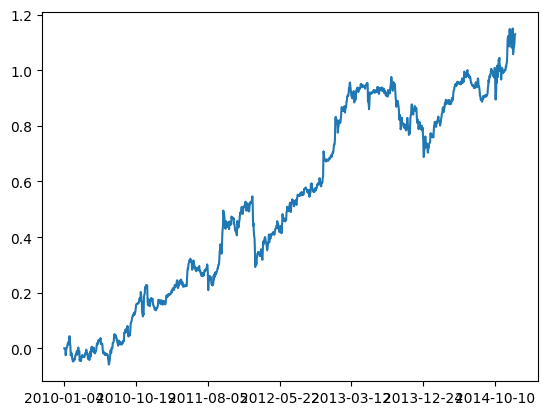

In [279]:
alpha_7.get_stats()

In [280]:
alpha_7.check_parametrs()


Results of Tests:
--------------------
Cumsum test passed.
Sharpe test passed.
Turnover test passed.


In [281]:
class Alpha_8(Alpha):
    def calc_weights(self):
        self.weights = self.volume / self.volume.shift(20)
        self.rank()

In [282]:
alpha_8 = Alpha_8(data_dict, start_date, end_date)

In [283]:
alpha_8.decay(4)

In [284]:
alpha_8.cut_middle(1000)

In [285]:
alpha_8.truncate()

,Sharpe Ratio,Turnover,Cumulative Return,Drawdown
2010,1.336270,0.535298,-0.004169,0.013519
2011,3.498030,0.596311,0.086239,0.011749
2012,1.857103,0.594492,0.024845,0.010637
2013,3.328890,0.578283,0.071750,0.007976
2014,2.733175,0.570708,0.058441,0.012928


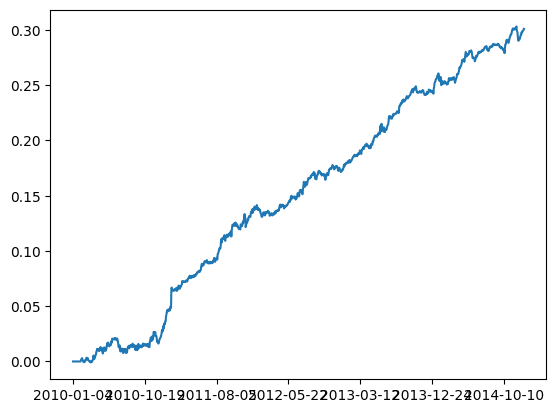

In [286]:
alpha_8.get_stats()

In [287]:
alpha_8.check_parametrs()


Results of Tests:
--------------------
Cumsum test passed.
Sharpe test passed.
Turnover test passed.


In [288]:
class Alpha_9(Alpha):
    def calc_weights(self):
        self.weights = alpha_1.weights * np.sign(volume - volume.shift(1))
        self.alpha_processing()

In [289]:
alpha_9 = Alpha_9(data_dict, start_date, end_date)

In [290]:
alpha_9.cut_middle(2000)

In [291]:
alpha_9.decay(4)

In [292]:
alpha_9.truncate()

In [293]:
alpha_9.decay(3)

,Sharpe Ratio,Turnover,Cumulative Return,Drawdown
2010,3.870095,0.718665,0.004021,0.013328
2011,0.529158,0.731632,-0.053414,0.029200
2012,1.047968,0.741114,0.002923,0.031167
2013,3.451130,0.730981,0.067345,0.016089
2014,1.798267,0.732037,-0.000934,0.029461


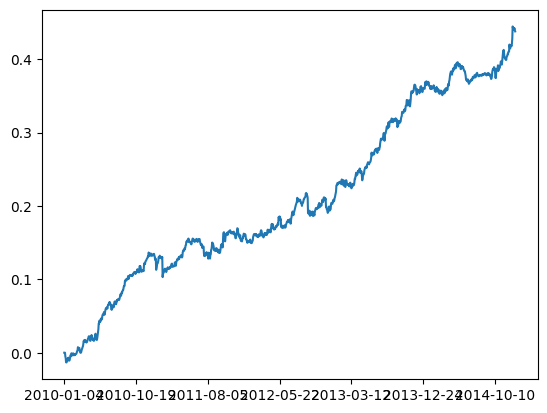

In [294]:
alpha_9.get_stats()

In [295]:
alpha_9.check_parametrs()


Results of Tests:
--------------------
Cumsum test passed.
Sharpe test passed.
Turnover test passed.


In [296]:
class Alpha_10(Alpha):
    def calc_weights(self):
        self.weights = self.close
        self.alpha_processing()

In [297]:
alpha_10 = Alpha_10(data_dict, start_date, end_date)

In [298]:
alpha_10.truncate()

In [299]:
alpha_10.cut_outliers(50)

In [300]:
alpha_10.truncate()

,Sharpe Ratio,Turnover,Cumulative Return,Drawdown
2010,2.211838,0.018849,-0.195709,0.026179
2011,1.283521,0.022225,-0.332549,0.064832
2012,1.079058,0.022329,-0.007673,0.043006
2013,2.019793,0.021092,0.263804,0.026716
2014,0.423350,0.021823,-0.659019,0.071917


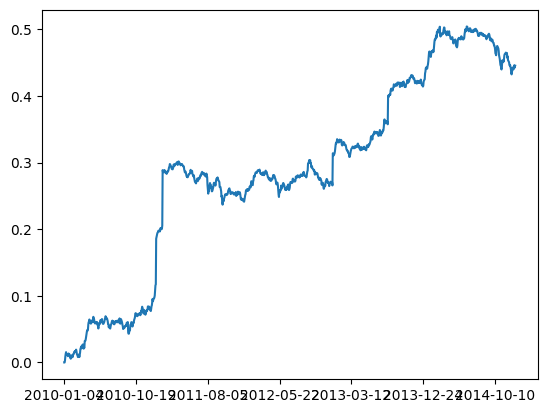

In [301]:
alpha_10.get_stats()

In [302]:
alpha_10.check_parametrs()


Results of Tests:
--------------------
Cumsum test passed.
Sharpe test passed.
Turnover test passed.


In [303]:
class Alpha_11(Alpha):
    def calc_weights(self):
        self.weights =  alpha_7.weights * np.sign(volume - volume.shift(1))
        self.alpha_processing()

In [304]:
alpha_11 = Alpha_11(data_dict, start_date, end_date)

In [305]:
alpha_11.cut_middle(1800)

In [306]:
alpha_11.decay(4)

In [307]:
alpha_11.truncate()

In [308]:
alpha_11.truncate()

In [309]:
alpha_11.decay(2)

,Sharpe Ratio,Turnover,Cumulative Return,Drawdown
2010,0.852801,0.789224,-0.066270,0.065578
2011,2.662366,0.761410,0.060294,0.022951
2012,2.356433,0.767723,0.335443,0.028455
2013,0.235837,0.752477,0.169024,0.042356
2014,1.061619,0.755221,-0.193140,0.029596


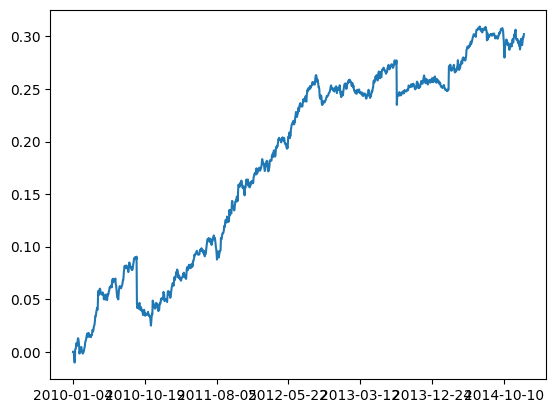

In [310]:
alpha_11.get_stats()

In [311]:
alpha_11.check_parametrs()


Results of Tests:
--------------------
Cumsum test passed.
Sharpe test passed.
Turnover test passed.


In [312]:
class Alpha_12(Alpha):
    def calc_weights(self):
        self.weights =  -(volume/(volume.shift(1) + volume.shift(2) + volume.shift(3)))*(-alpha_11.weights * alpha_10.weights + alpha_5.weights * alpha_BOSS_OF_CORRELATIONS.calc_corr(alpha_11.pnl, alpha_5.pnl) * np.sign(close - close.shift(1)))
        self.alpha_processing()

In [313]:
 alpha_BOSS_OF_CORRELATIONS.calc_corr(alpha_11.pnl, alpha_5.pnl)

0.15814458746720417

In [314]:
alpha_12 = Alpha_12(data_dict, start_date, end_date)

In [315]:
alpha_12.truncate()

In [316]:
alpha_12.cut_middle(1000)

In [317]:
alpha_12.decay(5)

,Sharpe Ratio,Turnover,Cumulative Return,Drawdown
2010,2.382397,0.787399,0.242746,0.016433
2011,1.902953,0.798650,0.043739,0.042761
2012,0.575102,0.763577,0.033499,0.036082
2013,1.378873,0.774147,0.097542,0.025505
2014,0.627809,0.783754,0.107786,0.054021


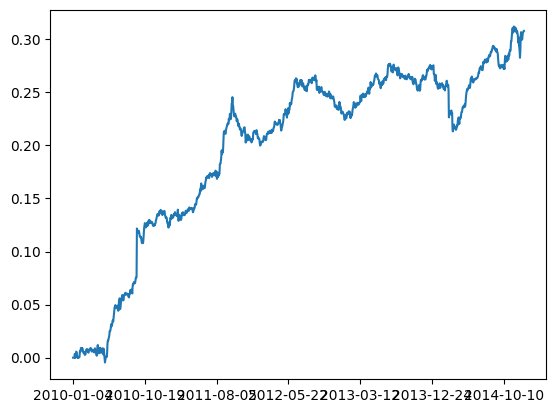

In [318]:
alpha_12.get_stats()

In [319]:
alpha_12.check_parametrs()


Results of Tests:
--------------------
Cumsum test passed.
Sharpe test passed.
Turnover test passed.


In [320]:
pnl_data = pd.DataFrame({
    'alpha_1': alpha_1.pnl,
    'alpha_2': alpha_2.pnl,
    'alpha_3': alpha_3.pnl,
    'alpha_4': alpha_4.pnl,
    'alpha_5': alpha_5.pnl,
    'alpha_6': alpha_6.pnl,
    'alpha_7': alpha_7.pnl,
    'alpha_8': alpha_8.pnl,
    'alpha_9': alpha_9.pnl,
    'alpha_10': alpha_10.pnl,
    'alpha_11': alpha_11.pnl,
    'alpha_12': alpha_12.pnl,
})

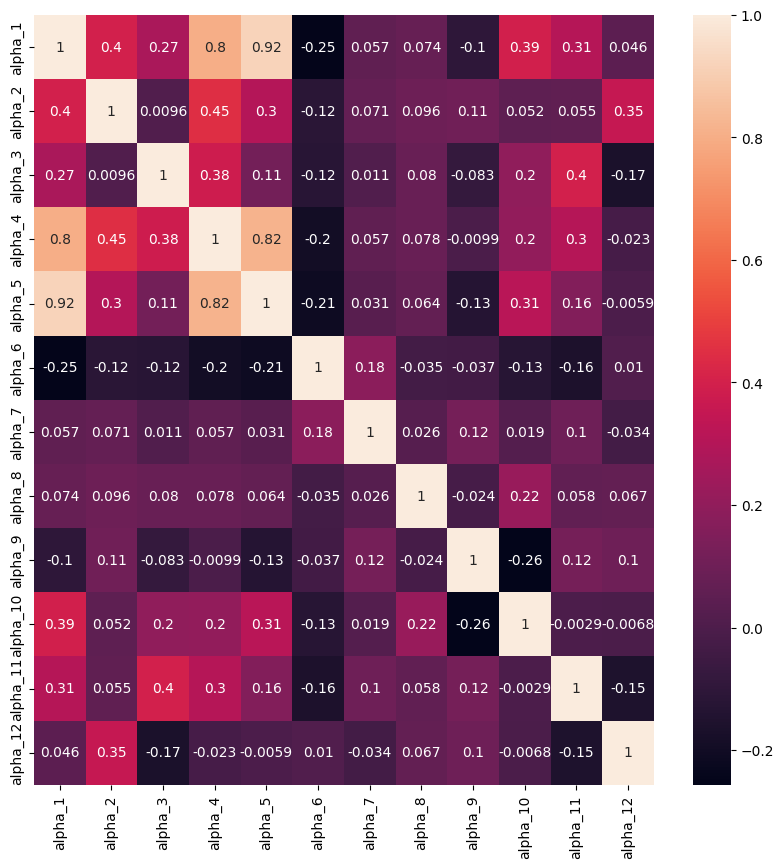

In [321]:
alpha_BOSS_OF_CORRELATIONS.plot_correlation(pnl_data)

In [322]:
alpha_BOSS_OF_CORRELATIONS.calc_corr(alpha_2.pnl, alpha_9.pnl)

0.10585013849695801

In [323]:
class Portfolio():
    def __init__(self, data_dict, start_date, end_date, alphas):
        self.start_date = start_date
        self.end_date = end_date
        self.opn = data_dict['Open']
        self.close = data_dict['Close']
        self.volume = data_dict['Volume']
        self.low = data_dict['Low']
        self.high = data_dict['High']
        self.alphas = alphas 
        self.weights = data_dict['Close']
        self.calc_weights()
        self.turnover = self.calc_turnover()
        self.pnl = self.calc_pnl()
        self.cumsum = self.calc_cumsum()
        self.cumrtrn = self.calc_cumrtrn()
        self.sharpe = self.calc_sharpe()
        self.drawdown = self.calc_drawdown()
    
    def calc_turnover(self, start_date=None, end_date=None):
        start_date = start_date if start_date is not None else self.start_date
        end_date = end_date if end_date is not None else self.end_date
        turnovers = []
        for year_start in pd.date_range(start=start_date, end=end_date - relativedelta(years=1), freq='Y'):
            year_end = year_start + relativedelta(years=1)
            turnovers.append(self.weights.loc[year_start.isoformat():year_end.isoformat()].diff().abs().sum(axis=1).mean())
        return turnovers
    
    def calc_weights(self):
        pass
    
    def calc_pnl(self, start_date=None, end_date=None):
        start_date = start_date if start_date is not None else self.start_date
        end_date = end_date if end_date is not None else self.end_date
        return (self.close.pct_change() * self.weights.shift(2)).sum(axis=1).loc[start_date.isoformat():end_date.isoformat()]
    
    def calc_cumrtrn(self, start_date=None, end_date=None):
        start_date = start_date if start_date is not None else self.start_date
        end_date = end_date if end_date is not None else self.end_date
        cumrtrns = []
        length = len(self.cumsum)
        i = 252
        while i < length:
            cumrtrns.append(self.cumsum.iloc[i] - self.cumsum.iloc[i - 252])
            i = i + 252
            if np.abs(i - length - 1) < 5: 
                i = length - 1
        if length < 252:
            cumrtrns.append(self.cumsum.iloc[length] - self.cumsum.iloc[0])
        return cumrtrns 
    
    
    def calc_cumsum(self, start_date=None, end_date=None):
        start_date = start_date if start_date is not None else self.start_date
        end_date = end_date if end_date is not None else self.end_date
        return self.pnl.cumsum().loc[start_date.isoformat():end_date.isoformat()]
        
    def calc_sharpe(self, start_date=None, end_date=None):
        start_date = start_date if start_date is not None else self.start_date
        end_date = end_date if end_date is not None else self.end_date
        sharpes = []
        for year_start in pd.date_range(start_date, end_date - relativedelta(years=1), freq='Y'):
            year_end = year_start + relativedelta(years=1)
            sharpes.append(self.pnl.loc[year_start.isoformat():year_end.isoformat()].mean() / self.pnl.loc[year_start.isoformat():year_end.isoformat()].std() * np.sqrt(252))
        return sharpes
    
    def calc_cumsum(self, start_date=None, end_date=None):
        start_date = start_date if start_date is not None else self.start_date
        end_date = end_date if end_date is not None else self.end_date
        return self.pnl.cumsum().loc[start_date.isoformat():end_date.isoformat()]
        
    def calc_sharpe(self, start_date=None, end_date=None):
        start_date = start_date if start_date is not None else self.start_date
        end_date = end_date if end_date is not None else self.end_date
        sharpes = []
        for year_start in pd.date_range(start_date, end_date - relativedelta(years=1), freq='Y'):
            year_end = year_start + relativedelta(years=1)
            sharpes.append(self.pnl.loc[year_start.isoformat():year_end.isoformat()].mean() / self.pnl.loc[year_start.isoformat():year_end.isoformat()].std() * np.sqrt(252))
        return sharpes
    
    def calc_drawdown(self, start_date=None, end_date=None):
        start_date = start_date if start_date is not None else self.start_date
        end_date = end_date if end_date is not None else self.end_date
        dd = []
        for year_start in pd.date_range(start_date, end_date - relativedelta(years=1), freq='Y'):
            year_end = year_start + relativedelta(years=1)
            mdd = 0
            mcpnl = 0
            cumsum = self.calc_cumsum(year_start, year_end)
            for a in cumsum:
                mcpnl = max(a,mcpnl)
                mdd = max(mcpnl - a,mdd)
            dd.append(mdd)    
        return dd
    
    def get_stats(self, start_date=None, end_date=None):
        start_date = start_date if start_date is not None else self.start_date
        end_date = end_date if end_date is not None else self.end_date
        self.portfolio_update(start_date, end_date)
        stats_data = {
        'Sharpe Ratio': self.sharpe,
        'Turnover': self.turnover,
        'Cumulative Return': self.cumrtrn,
        'Drawdown': self.drawdown
        }
        stats_df = pd.DataFrame(stats_data)
        stats_df.index = pd.date_range(start_date, end_date, freq='Y')[1:].year
        self.plot()
        return stats_df
        
    def plot(self):
        self.cumsum.plot()
        
    def portfolio_update(self, start_date=None, end_date=None):
        start_date = start_date if start_date is not None else self.start_date
        end_date = end_date if end_date is not None else self.end_date
        
        self.turnover = self.calc_turnover(start_date,end_date)
        self.pnl = self.calc_pnl(start_date,end_date)
        self.cumsum = self.calc_cumsum(start_date,end_date)
        self.sharpe = self.calc_sharpe(start_date,end_date)
        self.drawdown = self.calc_drawdown(start_date,end_date)
        
    def portfolio_processing(self):
        self.neutralization()
        self.normalization()
    
    def normalization(self):
        self.weights = self.weights.div(self.weights.abs().sum(axis=1),axis=0)
    
    def neutralization(self):
        self.weights = self.weights.sub(self.weights.mean(axis=1), axis=0)

In [324]:
class P_1(Portfolio):
    def calc_weights(self):
        length = len(alphas)
        portfolio = pd.DataFrame(0, index = self.close.index, columns = self.close.columns)
        for i in range(length):
            portfolio = portfolio + alphas[i].weights * (1/length)
        self.weights = portfolio
        self.portfolio_processing()

In [325]:
alphas = [alpha_2, alpha_3, alpha_4, alpha_6, alpha_7, alpha_8, alpha_9, alpha_10, alpha_11, alpha_12,]

In [326]:
P_1 = P_1(data_dict, start_date, end_date, alphas)

In [327]:
weights = alpha_11.cumsum.iloc[-1]  + alpha_12.cumsum.iloc[-1] + alpha_2.cumsum.iloc[-1] + alpha_3.cumsum.iloc[-1] + alpha_4.cumsum.iloc[-1] + alpha_6.cumsum.iloc[-1] + alpha_7.cumsum.iloc[-1] + alpha_8.cumsum.iloc[-1] + alpha_9.cumsum.iloc[-1] + alpha_10.cumsum.iloc[-1]

In [328]:
 weights / 10

0.4696854902013074

,Sharpe Ratio,Turnover,Cumulative Return,Drawdown
2010,3.687746,0.533519,0.204896,0.030775
2011,4.804360,0.595284,0.322852,0.028159
2012,2.404593,0.567112,0.174593,0.066066
2013,1.016028,0.550406,0.071063,0.062826
2014,3.202729,0.581294,0.238689,0.032753


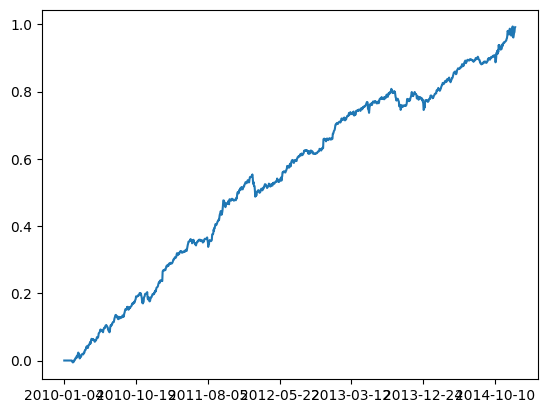

In [329]:
P_1.get_stats()

In [330]:
P_1.cumsum.iloc[-1]

0.9915323908472132

In [331]:
df_data = {'Alpha_{}'.format(i+1): alphas[i].sharpe for i in range(10)}
sharpe_df = pd.DataFrame(df_data)

In [350]:
sharpe_df = sharpe_df.shift(1).fillna(1/10)

In [351]:
sharpe_df

,Alpha_1,Alpha_2,Alpha_3,Alpha_4,Alpha_5,Alpha_6,Alpha_7,Alpha_8,Alpha_9,Alpha_10
0,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.977807,1.452526,0.418588,1.006584,0.830659,1.336270,3.870095,2.211838,0.852801,2.382397
3,2.047876,2.193576,2.211699,2.326136,1.947689,3.498030,0.529158,1.283521,2.662366,1.902953
4,2.504189,2.157250,2.303189,0.833634,1.012026,1.857103,1.047968,1.079058,2.356433,0.575102


In [205]:
portfolio = pd.DataFrame(0, index = close.index, columns = close.columns) 

In [359]:
class P_2(Portfolio):
    def calc_weights(self):
        length = len(alphas)
        portfolio = pd.DataFrame(0, index = self.close.index, columns = self.close.columns)
        for i in range(length):
            y_1 = alphas[i].weights.copy()
            y_2 = alphas[i].weights.copy()
            y_3 = alphas[i].weights.copy()
            y_4 = alphas[i].weights.copy()
            y_5 = alphas[i].weights.copy()
            
            y_1[~(y_1.index >= '2010-01-04') & (y_1.index <= '2010-12-31')] = 0
            y_2[~(y_2.index >= '2011-01-01') & (y_2.index <= '2011-12-31')] = 0
            y_3[~(y_3.index >= '2012-01-01') & (y_3.index <= '2012-12-31')] = 0
            y_3[~(y_4.index >= '2013-01-01') & (y_4.index <= '2013-12-31')] = 0
            y_4[~(y_5.index >= '2014-01-01') & (y_5.index <= '2014-12-31')] = 0
            
            y_1 *= sharpe_df.iloc[0].iloc[i]
            y_2 *= sharpe_df.iloc[1].iloc[i]
            y_3 *= sharpe_df.iloc[2].iloc[i]
            y_4 *= sharpe_df.iloc[3].iloc[i]
            y_5 *= sharpe_df.iloc[4].iloc[i]
            
            portfolio += y_1
            portfolio += y_2
            portfolio += y_3
            portfolio += y_4
            portfolio += y_5
            
        self.weights = portfolio
        self.portfolio_processing()

In [360]:
P_2 = P_2(data_dict, start_date, end_date, alphas)

,Sharpe Ratio,Turnover,Cumulative Return,Drawdown
2010,3.339951,0.512184,0.162182,0.022345
2011,4.683332,0.574167,0.299054,0.028911
2012,2.921972,0.554052,0.165059,0.045993
2013,1.961993,0.572819,0.098298,0.039675
2014,3.312974,0.585006,0.207763,0.025985


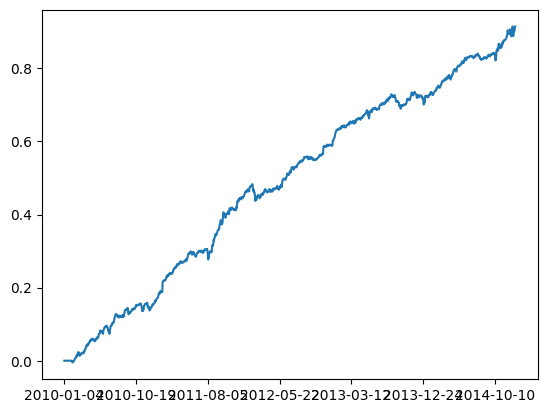

In [361]:
P_2.get_stats()

In [357]:
P_2.cumsum.iloc[-1]

0.914641861223525

In [358]:
class P_3(Portfolio):
    def calc_weights(self):
        length = len(alphas)
        portfolio = pd.DataFrame(0, index = self.close.index, columns = self.close.columns)
        cumprod = 0
        for alpha in alphas:
            cumprod = cumprod + np.prod(alpha.sharpe)
        for alpha in alphas:
            portfolio += alpha.weights *  np.prod(alpha.sharpe) / cumprod 
        self.weights = portfolio
        self.portfolio_processing()

In [144]:
P_3 = P_3(data_dict, start_date, end_date, alphas)

,Sharpe Ratio,Turnover,Cumulative Return,Drawdown
2010,2.390585,0.546732,0.054616,0.011637
2011,3.243157,0.604954,0.115166,0.016846
2012,2.393428,0.603810,0.056508,0.007374
2013,4.822926,0.590279,0.116122,0.008317
2014,1.619079,0.587433,0.051951,0.026891


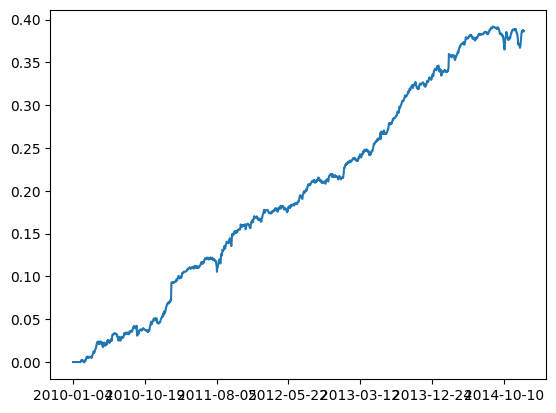

In [145]:
P_3.get_stats()

In [146]:
portfolios_pnl_data = pd.DataFrame({
    'P_1': P_1.pnl,
    'P_2': P_2.pnl,
    'P_3': P_3.pnl,
})

AttributeError: type object 'P_1' has no attribute 'pnl'

In [ ]:
alpha_BOSS_OF_CORRELATIONS.plot_correlation(portfolios_pnl_data )